In [ ]:
# to_save, to_load = False, True
# session_file = "./tmp/TIC_417436377_EA_contaminated_by_TIC_417436387.pkl"

# # load/save the notebook session
# # https://dill.readthedocs.io/en/latest/
# if True: 
#     import dill
#     dill.load_module(session_file)
#     print(f"Notebook session loaded from  {session_file}")

# if True:  # save the notebook session
#     import dill
#     dill.dump_module(session_file)
#     print(f"Notebook session saved in {session_file}")


In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 193822785 / Gaia DR3 1349910664971031680  Analysis (EA, w/ETV)

- new VSX entry
- ETV with ~500 d period, comparable to the AB /SB results from Gaia DR3 NSS

## TESS Data

In [2]:
tic = 193822785

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr_unfiltered = sr  # keep a copy
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])
# sr = sr[sr.author == "QLP"]  # for uniformity, only 1 sector (3) has no QLP data
# sr = lke._sort_chronologically(sr)

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

# Note: only 1 sector of ready made lightcurve
# if needed, lightcurves can be created from sectors 37, 63, 64 (and in the future 90, 99, 100, 101)
lcc_tess = sr.download_all()
lcc_tess

SearchResult containing 10 data products.

 #     mission     year author exptime target_name distance proposal_id
                                  s                 arcsec             
--- -------------- ---- ------ ------- ----------- -------- -----------
  0 TESS Sector 25 2020   SPOC     120   193822785      0.0     G022119
  1 TESS Sector 26 2020   SPOC     120   193822785      0.0     G022119
  2 TESS Sector 40 2021   SPOC     120   193822785      0.0      G04171
  3 TESS Sector 52 2022   SPOC     120   193822785      0.0      G04171
  4 TESS Sector 53 2022   SPOC     120   193822785      0.0      G04171
  5 TESS Sector 54 2022   SPOC     120   193822785      0.0      G04171
  6 TESS Sector 74 2024   SPOC     120   193822785      0.0      G06057
  7 TESS Sector 79 2024   SPOC     120   193822785      0.0      G06057
  8 TESS Sector 80 2024   SPOC     120   193822785      0.0      G06057
  9 TESS Sector 81 2024   SPOC     120   193822785      0.0      G06057

LightCurveCollection of 10 objects:
    0: <TessLightCurve LABEL="TIC 193822785" SECTOR=25 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 193822785" SECTOR=26 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 193822785" SECTOR=40 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 193822785" SECTOR=52 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 193822785" SECTOR=53 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 193822785" SECTOR=54 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 193822785" SECTOR=74 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    7: <TessLightCurve LABEL="TIC 193822785" SECTOR=79 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    8: <TessLightCurve LABEL="TIC 193822785" SECTOR=80 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    9: <TessLightCurve LABEL="TIC 193822785" SECTOR=81 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [ ]:
lc = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True,)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=1, alpha=0.9);
axs[0].get_figure().suptitle(f"Contaminant {lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);
[ax.set_ylim(0.9985, 1.001) for ax in axs];

## Gaia DR3 info (coordinate, etc.)

In [3]:
# reload(lke)
# reload (lket)
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic, radius_arcsec=15, magnitude_range=None,  pm_error_factor=None, pm_range_fraction=None, pm_range_minimum=None, 
                                                        calc_separation_from_first_row=True,  # assuming the first row is the target, it'd calculate more accurately the separation for Gaia DR3 Main
                                                        compact_columns=True, also_return_html=True, also_return_astrophysical=False, verbose_html=True, include_nss_summary_in_html=False)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


The target is also listed as an AB and SB with ~500 dperiod in [Gaia DR3 NSS](https://vizier.cds.unistra.fr/viz-bin/VizieR-4?-source=I/357&-c=17%3A55%3A59.25%20%2B45%3A52%3A26.42&-c.u=arcsec&-c.r=15&-c.eq=J2000&-out.add=_r&-out.add=_p&-sort=_r)


In [4]:
primary_name = f"TIC {tic}"
primary_name

'TIC 193822785'

## Combining all data

- Archival ASAS-SN, ZTF, and SuperWASP data exist, but they do not have the photometric precison needed:

http://asas-sn.ifa.hawaii.edu/skypatrol/objects/111669708476

https://ztf.snad.space/view/764108300007188

https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves?ID=764108300007188&COLLECTION=ztf_dr23&FORMAT=csv

- OPEN: Catalina data possiblty has the precision needed (marginal): 

http://nunuku.caltech.edu/cgi-bin/getcssconedb_release_img.cgi?RADec=268.99696+45.87425&Rad=0.2&DB=photcat&OUT=csv&SHORT=short&PLOT=plot#simtable


TESS # data points: 180568


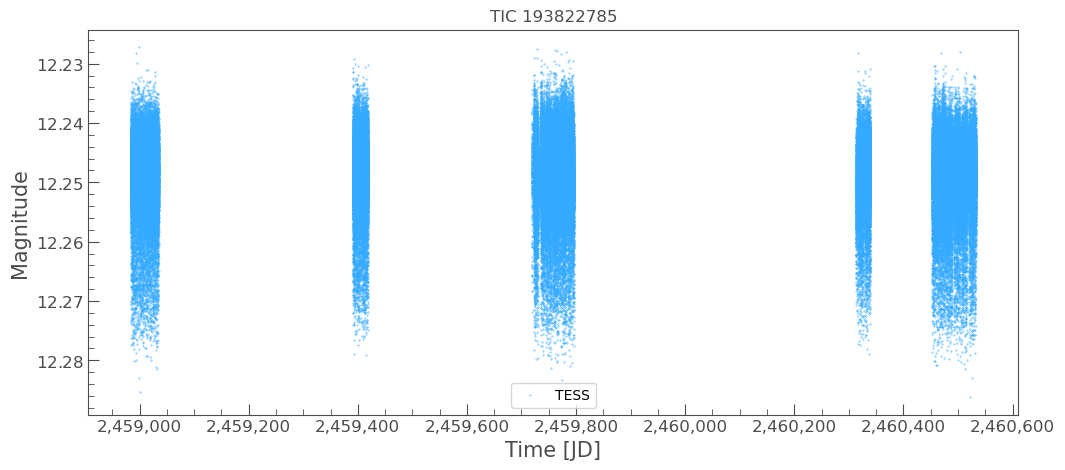

In [5]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)

# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
    }, 
    shift_to=None,
)

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) move it to the front
# plot_options[0][1]["zorder"] = 3  # default 2

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name, plot_options=plot_options);
# ax.set_ylim(15.2, 14.0);

## Final epoch / period / duration

- epoch / period / duration determined from MCMC model in the separate ETV analsysis

Adopted period / epoch / duration_hr:  0.966799 2458984.465 1.4 1.4
Min II phase: 0.5


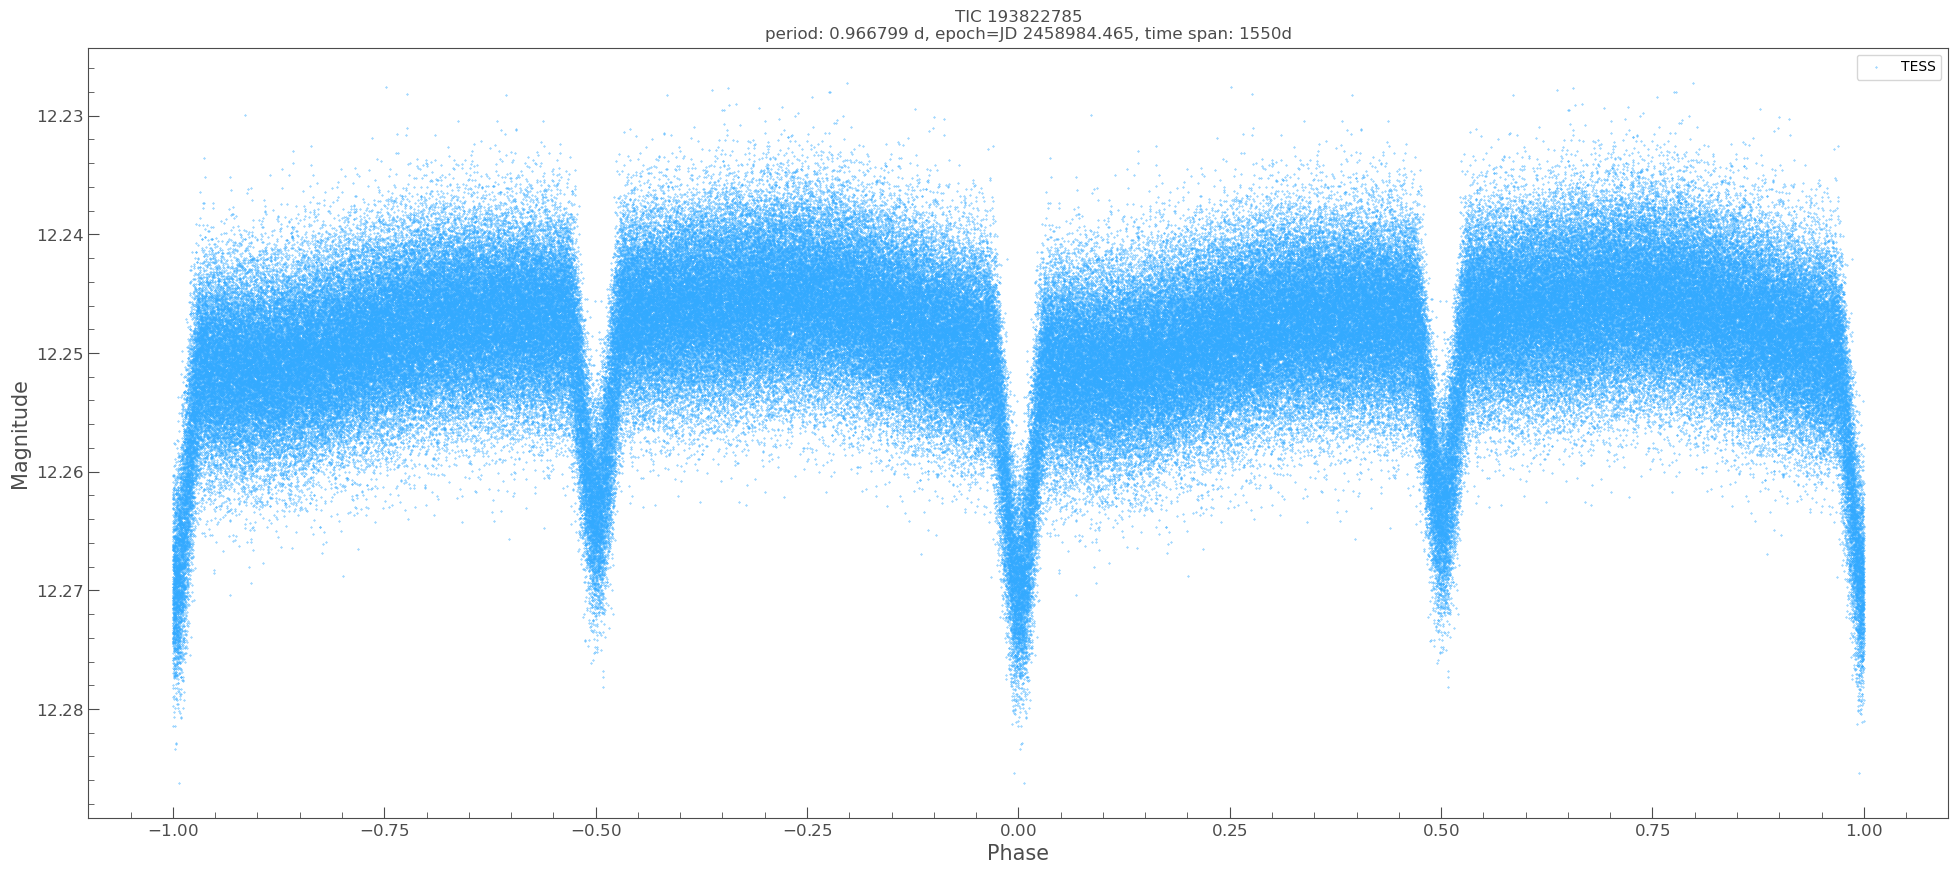

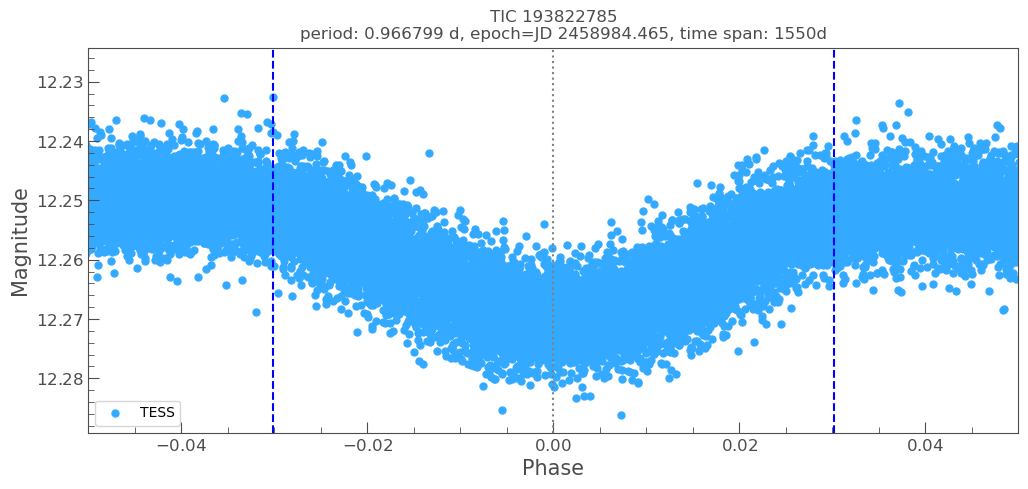

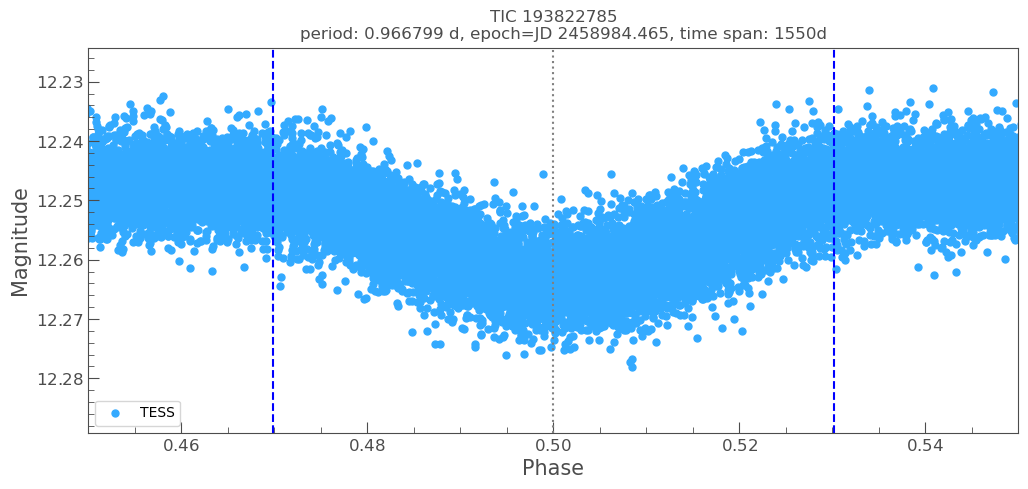

In [10]:
# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = 0.966799
epoch_time_btjd_final = 1984.466
epoch_time_hjd_final = round(lket.btjd_to_hjd_utc(epoch_time_btjd_final, target_coord), 3)  # need 3 digit to ensure it does look off visually
epoch_time_min_ii_btjd_final = epoch_time_btjd_final + period_final * 0.5
epoch_time_min_ii_hjd_final = round(lket.btjd_to_hjd_utc(epoch_time_min_ii_btjd_final, target_coord), 3) 

duration_hr_min_i_final = 1.4
duration_hr_min_ii_final = 1.4

# Note: circular
epoch_phase_min_ii_final = 0.5

print("Adopted period / epoch / duration_hr: ", period_final, epoch_time_hjd_final, duration_hr_min_i_final, duration_hr_min_ii_final)
print("Min II phase:", epoch_phase_min_ii_final)

# --- Plot them to verify ---

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    # plot_options=plot_options,
);


# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.05, 0.05);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_final  ,
    plot_options=plot_options_zoom,
    figsize=(12, 5),
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(epoch_phase_min_ii_final, c="gray", linestyle="dotted");
ax.set_xlim(epoch_phase_min_ii_final  -0.05, epoch_phase_min_ii_final  +0.05);  # to see Min II in details


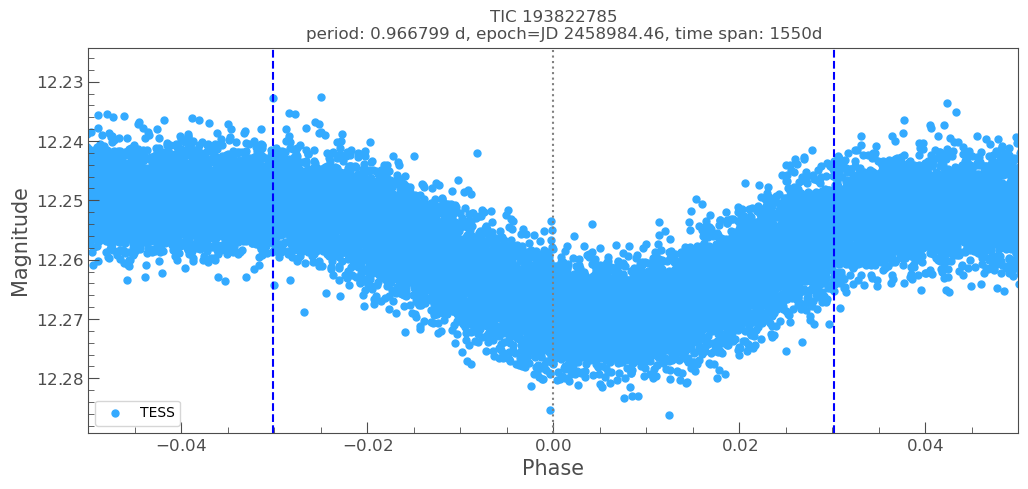

In [11]:
# demonstrate the differnce if Min I epoch is in 2 digits instead of 3 digits

_et = round(epoch_time_hjd_final, 2)
# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
plot_options_zoom[0][1]["s"] = 25
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final  ,
    epoch=Time(_et  , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(12, 5),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ylim = (None, None)
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.05, 0.05);  # to see primary in details


## Determine Magnitude Range


In [58]:
lc = lc_combined_dict["TESS"]

In [60]:
# determine max
for max_offset in [0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78]:
    lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + max_offset, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)
    # print("Max mag # num data points:", len(lc_zoom_max))
    max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)
    print(max_offset, round(float(max_flux_mag), 4))


0.66 12.2456
0.67 12.2459
0.68 12.2454
0.69 12.2456
0.7 12.2453
0.71 12.2456
0.72 12.2458
0.73 12.2457
0.74 12.2453
0.75 12.2448
0.76 12.246
0.77 12.246
0.78 12.2462


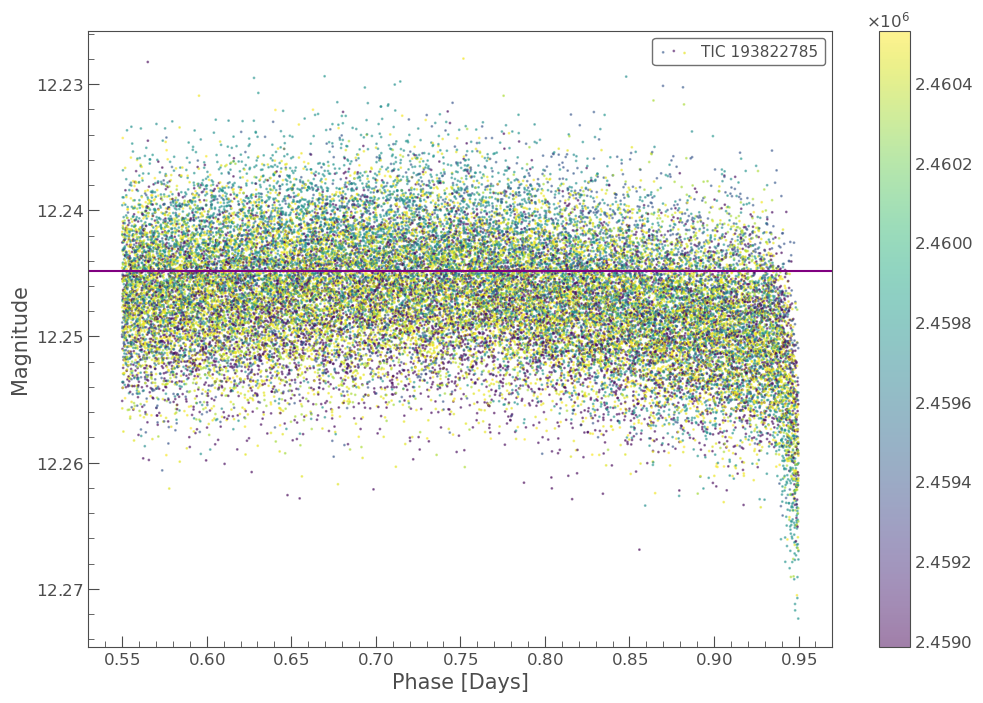

In [63]:
# zoom around max

# max is roughly at +0.7 / +0.75 d
lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final * 2)  # 2x period plot
lc_f_trunc = lc_f.truncate(0.75 - 0.2, 0.75 + 0.2)
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f_trunc , ax=ax, c=lc_f_trunc.time_original.value, alpha=0.5);
ax.axhline(12.2448, c="purple");

Max mag # num data points: 252
Min I mag # num data points: 262
Min II mag # num data points: 257
['12.2448', '12.2485', '12.2701', '12.2633']


(13.15, 0.025, 0.022, 0.015)

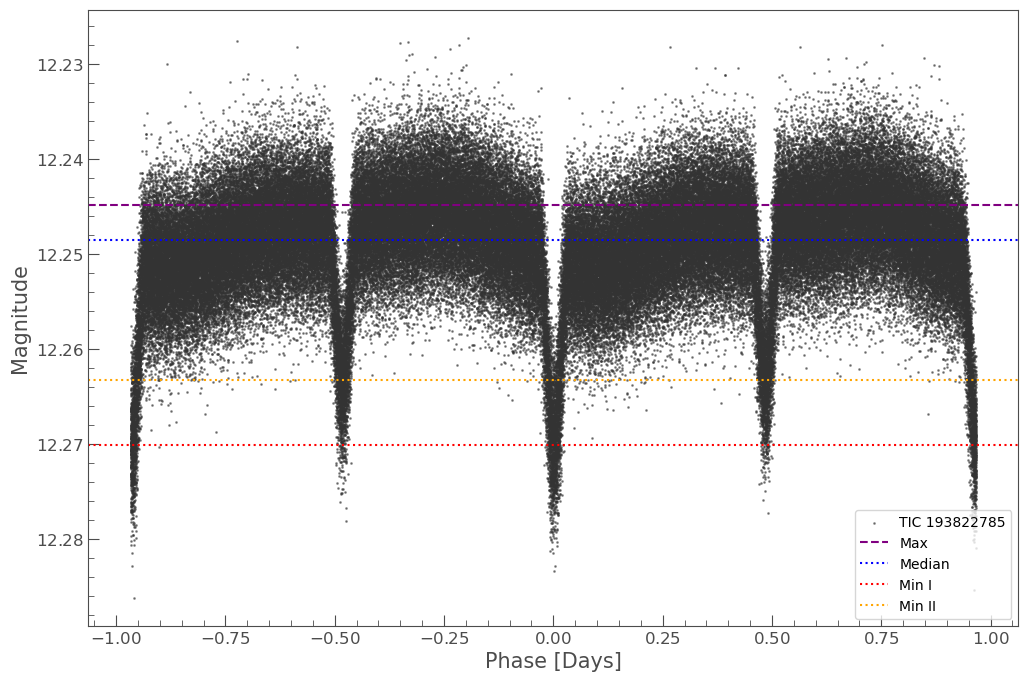

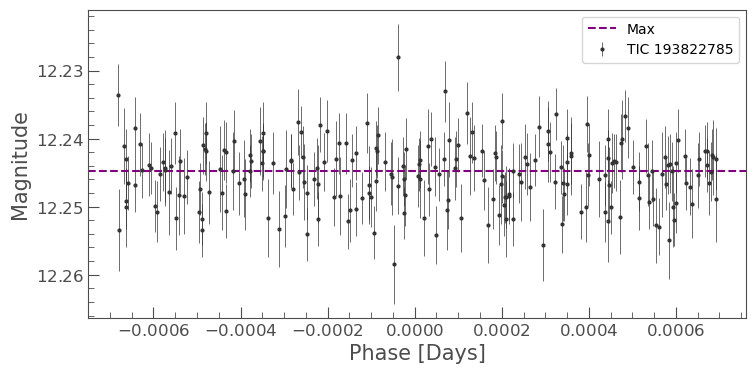

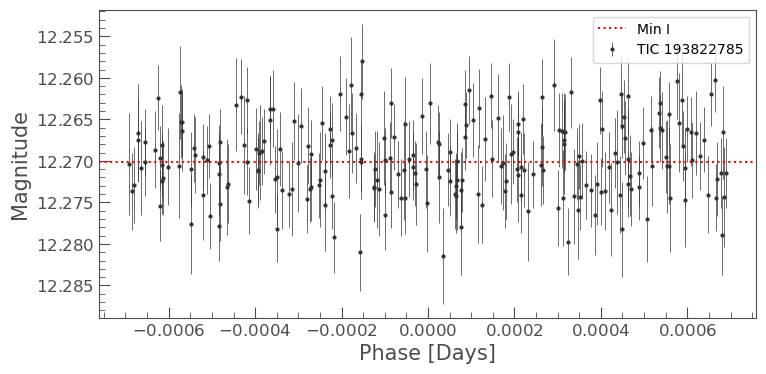

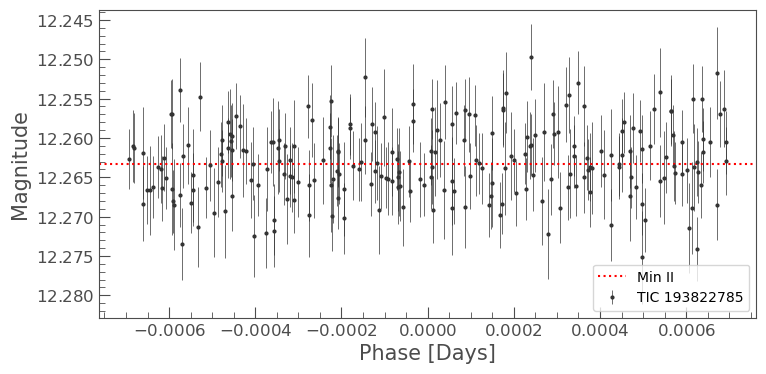

In [40]:
# %matplotlib widget
%matplotlib inline

# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict["TESS"]
# max_flux_mag = lc.flux.min().value  #
# min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_max = lc.fold(epoch_time=epoch_time_hjd_final + 0.75, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)
print("Max mag # num data points:", len(lc_zoom_max))
max_flux_mag = np.nanmedian(lc_zoom_max.flux.value)


lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)
print("Min I mag # num data points:", len(lc_zoom_min))
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)

lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd_final, period=period_final).truncate(0 - 1 /24/60, 0 + 1 /24/ 60)
print("Min II mag # num data points:", len(lc_zoom_min_ii))
min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)


lc_f = lc.fold(epoch_time=epoch_time_hjd_final, period=period_final * 2)  # 2x period plot
ax = tplt.lk_ax(figsize=(12, 8))
ax = tplt.scatter(lc_f, ax=ax, alpha=0.5);
ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.axhline(min_ii_flux_mag, c="orange", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");
# ax.set_xlim(-0.5, 0.5); 
ax.set_ylim(*ylim);

ax = tplt.errorbar(lc_zoom_max, marker="o");
ax.axhline(max_flux_mag, c="purple", linestyle="--", label="Max")
# ax.set_ylim(*ylim);
ax.legend();

ax = tplt.errorbar(lc_zoom_min, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
# ax.set_ylim(*ylim);
ax.legend();

ax = tplt.errorbar(lc_zoom_min_ii, marker="o");
ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
ax.legend(loc="lower right");

print([f"{v:.4f}" for v in [max_flux_mag, median_flux_mag, min_flux_mag, min_ii_flux_mag]])


# TESS only data, to report mean V mag and ampitude in TESS
mean_flux_v_mag = np.round(rs_all_cols["Vmag"][0], 2)  # V converted from Gaia DR3 

amp_flux_mag = np.round(np.abs(float(min_flux_mag - max_flux_mag)) , 3)  # in TESS band, probably don't have 4 digit precison

amp_min_i_flux_mag = np.round(np.abs(float(min_flux_mag - median_flux_mag)) , 3)  

amp_min_ii_flux_mag = np.round(np.abs(float(min_ii_flux_mag - median_flux_mag)) , 3)  


(mean_flux_v_mag, amp_flux_mag, amp_min_i_flux_mag, amp_min_ii_flux_mag)

## Plots for VSX

In [ ]:
# reload(lkem)
# Not needed
plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 4

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name, plot_options=plot_options);
# ax.set_title(ax.get_title() + "");

#### Phase Plot



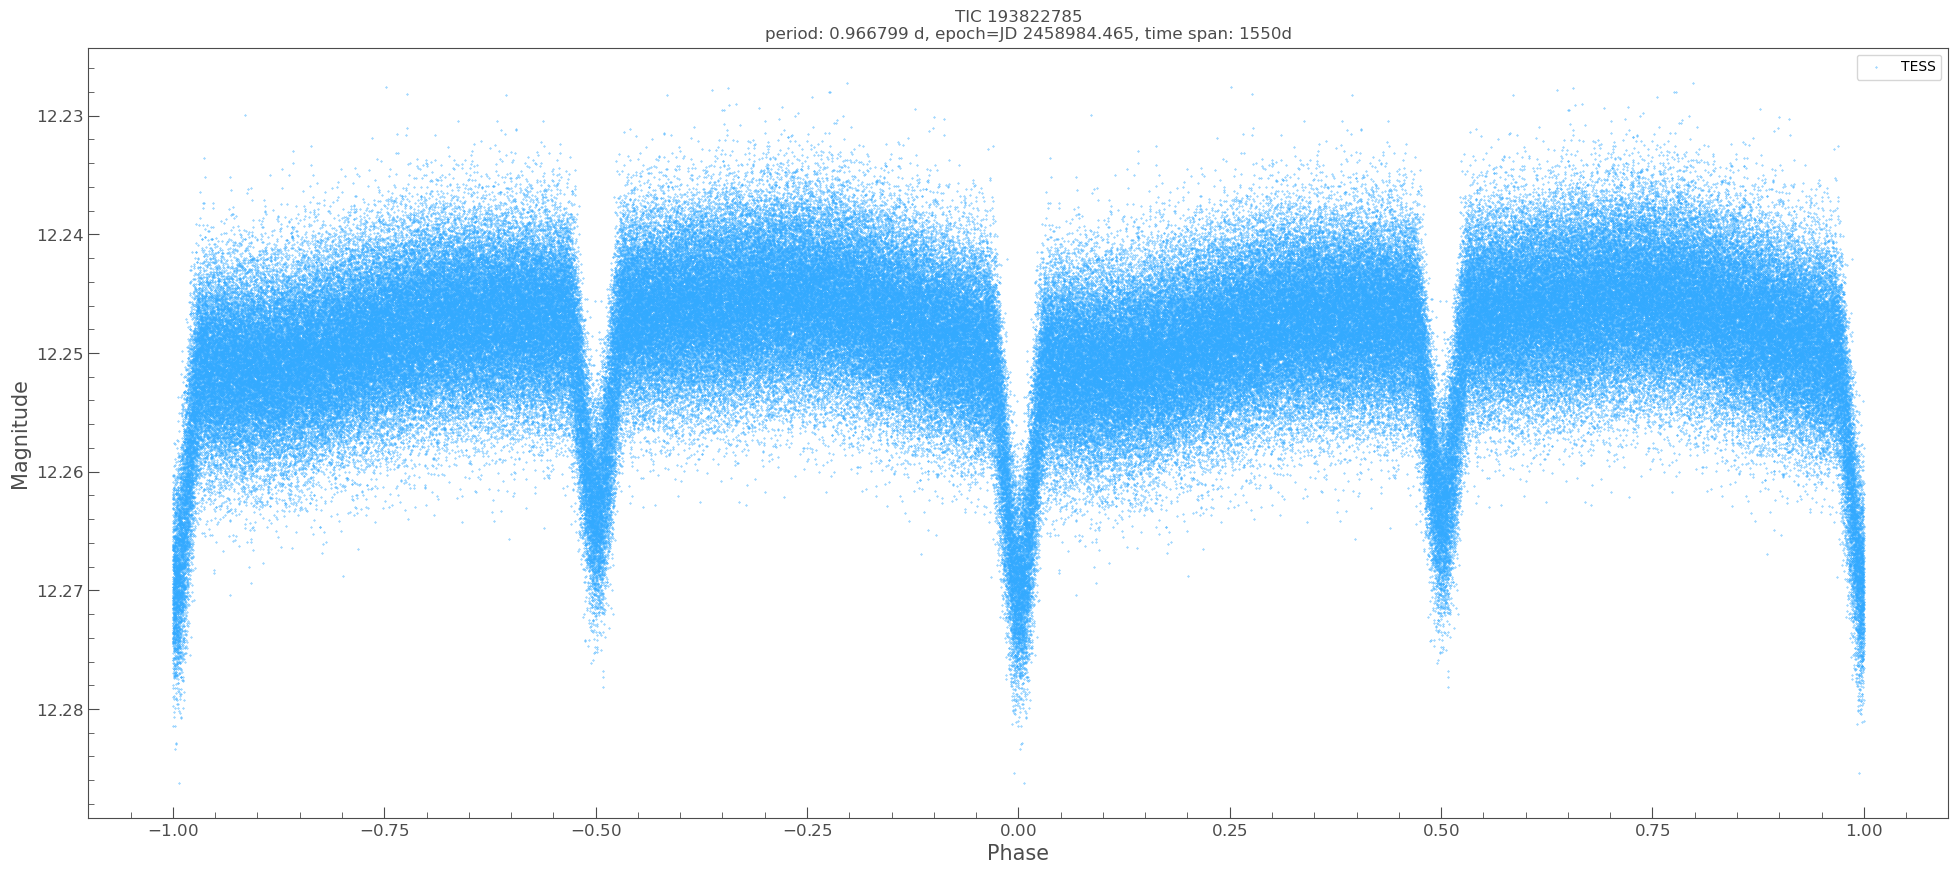

In [42]:
# reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# plot_options[0][1]["zorder"] = 3  # default 2
# plot_options[0][1]["s"] = 4
# plot_options[1][1]["markersize"] = 9

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_final,
    epoch=Time(epoch_time_hjd_final , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);
ylim = (None, None)
ax.set_ylim(*ylim);
# ax.set_title(ax.get_title() + "");


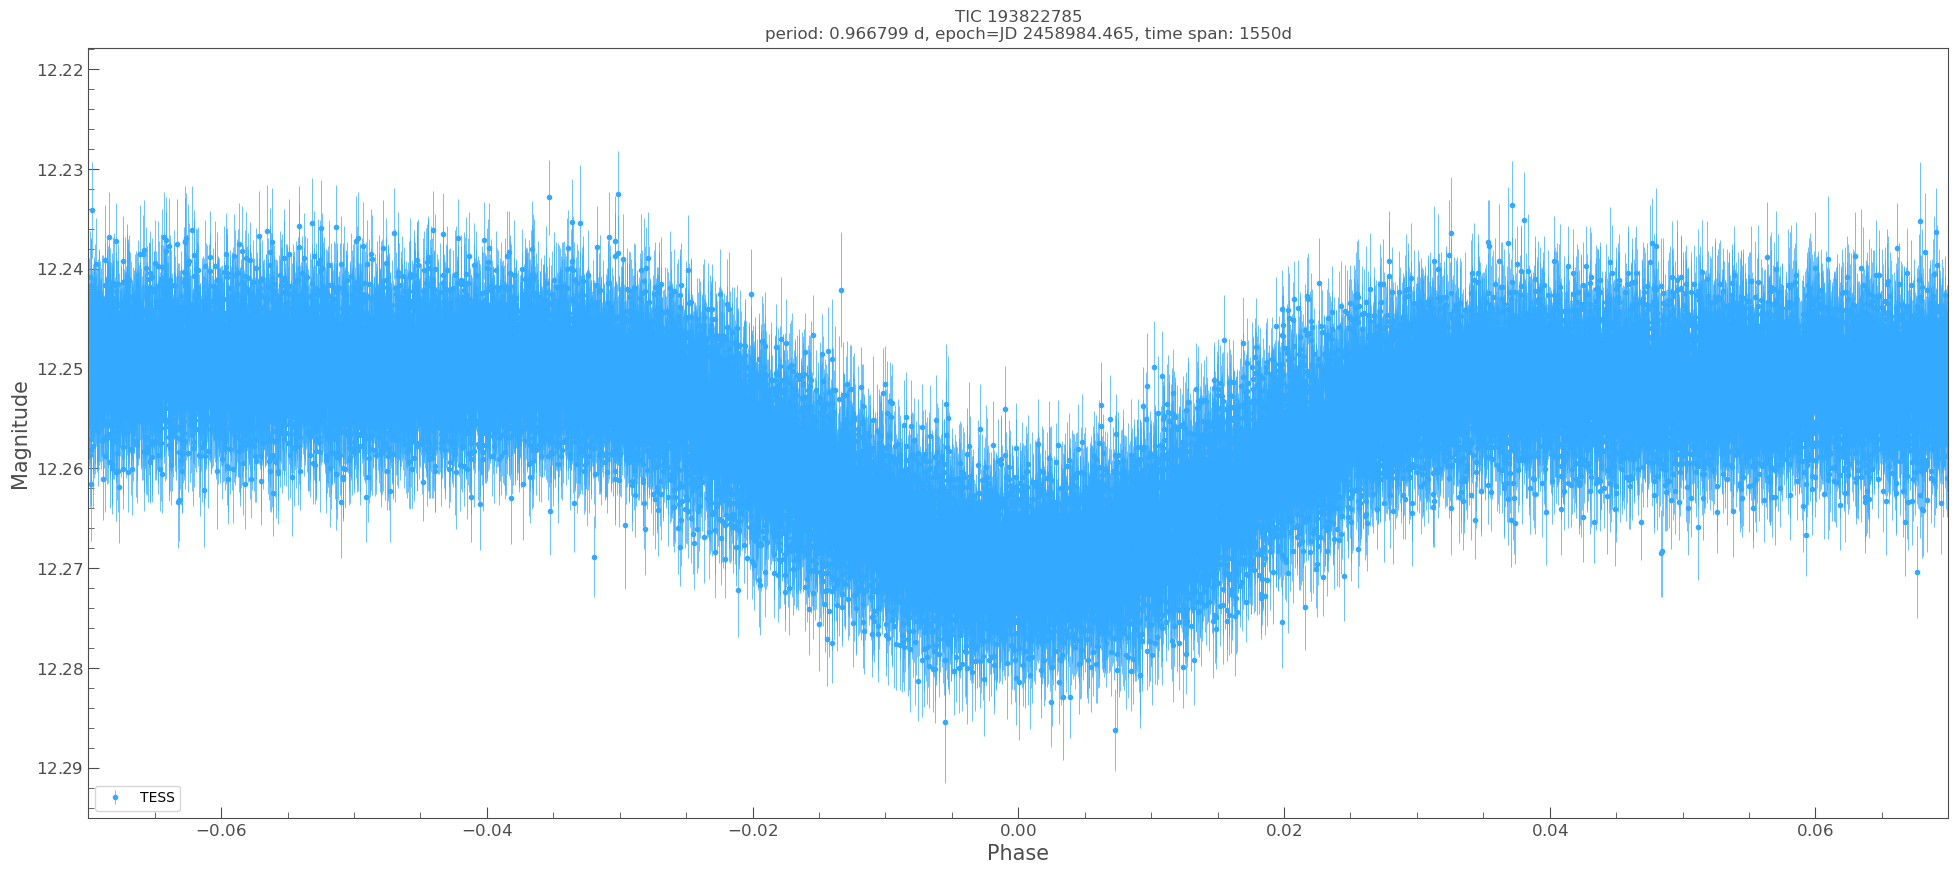

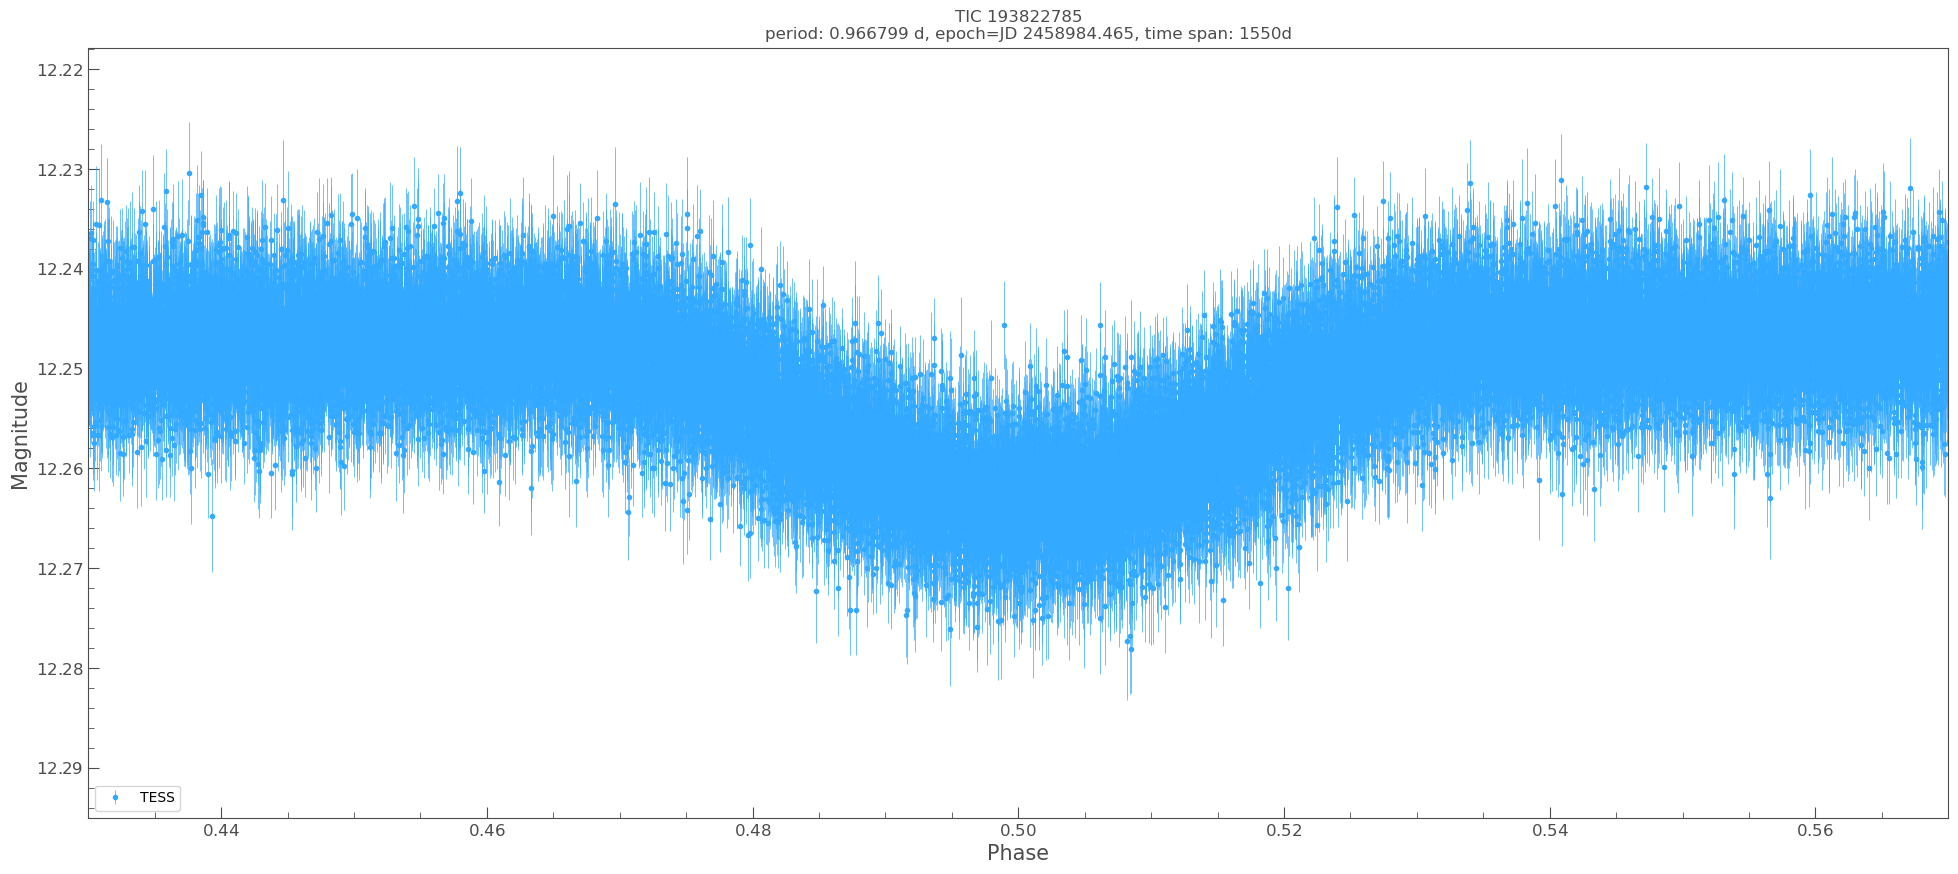

In [44]:

# zoom plot Min I
# - make TESS more visible:  larger dots
plot_options_zoom = lkem.get_default_plot_multi_bands_options_copy()
# plot_options_zoom[0][1]["s"] = 25  # larger dots
plot_options_zoom[0] = ('errorbar', {'marker': '.', 'c': '#3AF', 'linewidth': 0.5, 'ls': 'none'})  # use error bar

# to workaround astropy TypeError: cannot write to unmasked output when doing matplotlib errorbar  plot
_lc = lc_combined_dict['TESS'].copy()
_lc.flux_err = _lc.flux_err.filled(np.nan)

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    # lc_combined_dict,
    dict(TESS=_lc), 
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_i_final  ,  # for plotting only
    figsize=(24, 10),
    plot_options=plot_options_zoom,
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
# ax.axvline(0, c="gray", linestyle="dotted");
ax.set_xlim(-0.07, 0.07);  # to see primary in details


# zoom plot - Min II
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    # lc_combined_dict,
    dict(TESS=_lc), 
    period=period_final  ,
    epoch=Time(epoch_time_hjd_final   , format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    # duration_hr=duration_hr_min_ii_final  ,  # for plotting only
    duration_midpoint_phase=epoch_phase_min_ii_final  ,
    plot_options=plot_options_zoom,
    figsize=(24, 10),
    # mag_shift_precision=2,  #
);
ax.set_ylim(*ylim);
ax.legend(loc="lower left");
ax.set_xlim(epoch_phase_min_ii_final  -0.07, epoch_phase_min_ii_final  +0.07);  # to see Min II in details


### O-C from my ETV analysis

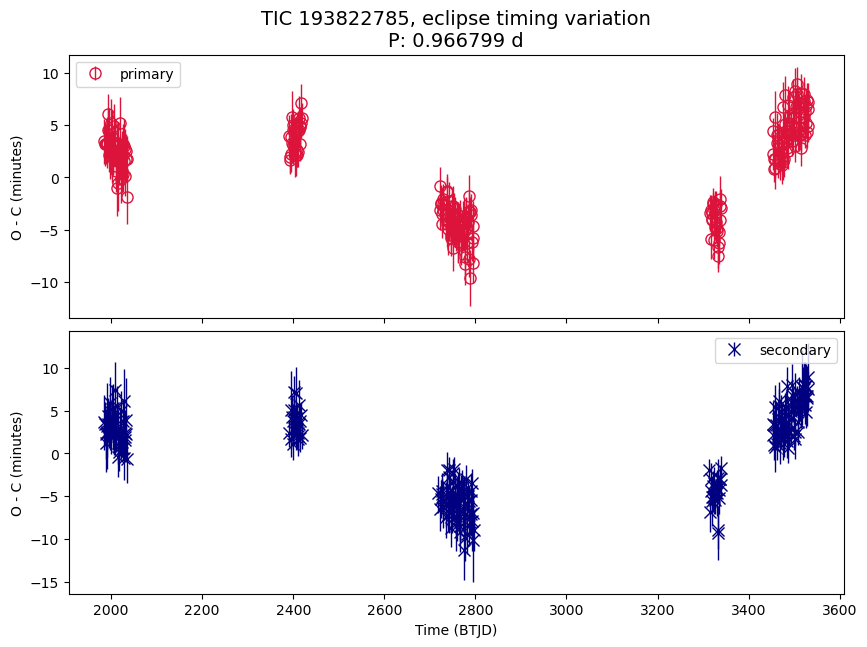

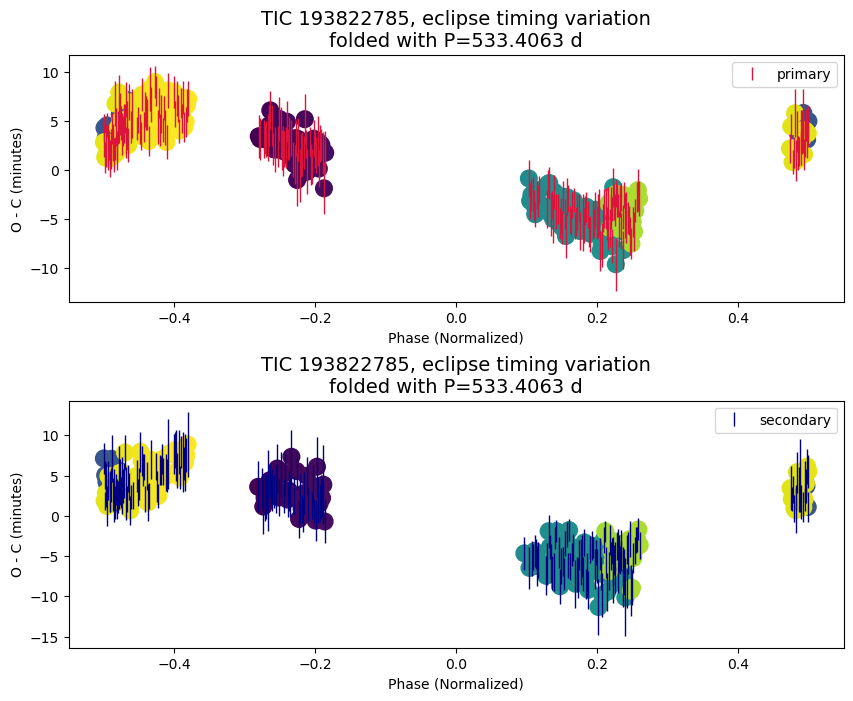


## VSX Report Table

In [45]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df


def vsx_phase(phase):
    # the phase I used above is from [-0.5, +0.5]
    # convert to the phase [0, 1[ used by VSX
    if phase < -0.5 or phase > 0.5:
        raise ValueError(f"Input phase needs to be in [-0.5, 0.5] range. Actual: {phase}")
    if phase >= 0:
        return phase 
    else: 
        return 1 + phase


In [57]:
import bibs_utils
# reload(bibs_utils)

# TIC are not added, given the entry refers to thw whole system per SO
other_names = f"UCAC4 680-061115,2MASS J17555927+4552274"  # ExoFOP  and  SIMBAD
other_names += ",GSC 03511-00465"  # -- https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ686bf736135686&-out.add=.&-source=I/255/out&GSC=0351100465
# not in WDS

remarks = (
    f"""Min I amplitude {amp_min_i_flux_mag} TESS. Min II amplitude {amp_min_ii_flux_mag} TESS, duration {100 * duration_hr_min_ii_final / 24 / period_final:.1f}% . """
    f"""O'Connell effect observed. """
    f"""Likely to have a third companion: eclipse timing variation with a period of ~500 d, comparable to the results from Gaia DR3 NSS (AB: ~550d, SB: ~548 d)."""
)

revision_comment = "Type, period, epoch, amplitudes, and eclipse duration from TESS data. Mean magnitude from APASS9 . Position and spectral type from Gaia DR3."


BIBS = bibs_utils.BIBS
vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA",
    Spectral_Type="K",  # Gaia DR3
    Spectral_Type_Uncertain=False,
    Maximum_Magnitude=f"13.15",  # APASS9, used by UCAC4, which in turn used by SIMBAD  -- https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ686bf736135686&-out.add=.&-source=II/336/apass9&-c=268.996872%20%2b45.874091,eq=J2000,rs=2
    Maximum_Magnitude_band="V",
    Minimum_Magnitude=f"{amp_flux_mag:}",   # in TESS from the plot above
    Minimum_Magnitude_band="TESS",  
    Minimum_Is_Amplitude=True,
    Period=f"{period_final}",  
    Epoch=f"{epoch_time_hjd_final:}",  
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_final / 24 / period_final:.1f}",
    Discoverer="A. Prša et al. (TESS)",   # TESS_EB paper
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference0_Name=BIBS.TESS_N,
    Reference0_Bib=BIBS.TESS_B,
    Reference1_Name=BIBS.TESSEB_N,  # for initial variable discovery
    Reference1_Bib=BIBS.TESSEB_B,  
    Reference2_Name=BIBS.GAIA_DR3_N,  # for position ans spectra
    Reference2_Bib=BIBS.GAIA_DR3_B,  
    Reference3_Bib=BIBS.GAIA_DR3_NSS_N,  # for AB / SB in remarks
    Reference3_Name=BIBS.GAIA_DR3_NSS_B,
    Reference4_Name="Henden, A. A.; et al., 2016, AAVSO Photometric All Sky Survey (APASS) DR9 (Henden+, 2016)",  # for mean Vmag
    Reference4_Bib="2016yCat.2336....0H",
)
# Possibly useful references but has no new data
# Czavalinga, D. R.; et al., 2023, New compact hierarchical triple system candidates identified using Gaia DR3  --- 2023A&A...670A..75C
# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ686bf881147f7d&-out.add=.&-source=J/A%2bA/670/A75/table1&recno=11
# - identifies the target as an EB with ETV (1 of hundreds), but no specific data
#
# Tokovinin, A., 2018, Updated Multiple Star Catalog (MSC): Dec 2023 (Tokovinin, 2018)  --- 2018yCat..22350006T
# https://vizier.cds.unistra.fr/viz-bin/VizieR-6?-source=J/ApJS/235/6/%2a&ID=17560%2b4552
# - in MSC


def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))


# Combined LC probably not needed for EA with no long term variation
# tic193822785_combined_plot.png : Combined light curve - Combined light curve from from TESS and corrected ASAS-SN; shifted to corrected ASAS-SN V.
# Zoom not needed
# tic193822785_phase_plot_eclipses_min_i.png : EA Phase Plot (Min I zoom) - EA Phase Plot, zoomed to Min I.
# tic193822785_phase_plot_eclipses_min_ii.png : EA Phase Plot (Min II zoom) - EA Phase Plot, zoomed to Min II.
print("""
tic193822785_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS data
tic193822785_oc.png : O-C Plot - O-C Plot from TESS data
tic193822785_phase_oc.png : O-C Phase Plot - O-C Phase Plot from TESS data
""")


Other Names (1 line each):
UCAC4 680-061115
2MASS J17555927+4552274
GSC 03511-00465

Min I amplitude 0.022 TESS. Min II amplitude 0.015 TESS, duration 6.0% . O'Connell Effect observed. Likely to have a third companion: eclipse timing variation with a period of ~500 d, comparable to the resutls from Gaia DR3 NSS (AB: ~550d, SB: ~548 d).

Type, period, epoch, amplitudes, and eclipse duration from TESS data. Mean magnitude from APASS9 . Position and spectral type from Gaia DR3.


Field  \
0                  Position   
1              Primary_Name   
2               Other_Names   
3             Variable_Type   
4             Spectral_Type   
5   Spectral_Type_Uncertain   
6         Maximum_Magnitude   
7    Maximum_Magnitude_band   
8         Minimum_Magnitude   
9    Minimum_Magnitude_band   
10     Minimum_Is_Amplitude   
11                   Period   
12                    Epoch   
13        Rise_Duration_Pct   
14               Discoverer   
15                  Remarks   
16         Revision_Comment   
17          Reference0_Name   
18           Reference0_Bib   
19          Reference1_Name   
20           Reference1_Bib   
21          Reference2_Name   
22           Reference2_Bib   
23           Reference3_Bib   
24          Reference3_Name   
25          Reference4_Name   
26           Reference4_Bib   

                                                                                                                                                                                                                                                           Value  
0                                                                                                                                                                                                                                268.99696000893, 45.87423977527  
1                                                                                                                                                                                                                                                  TIC 193822785  
2                                                                                                                                                                                                       UCAC4 680-061115,2MASS J17555927+4552274,GSC 03511-00465  
3                                                                                                                                                                                                                                                             EA  
4                                                                                                                                                                                                                                                              K  
5                                                                                                                                                                                                                                                          False  
6                                                                                                                                                                                                                                                          13.15  
7                                                                                                                                                                                                                                                              V  
8                                                                                                                                                                                                                                                          0.025  
9                                                                                                                                                                                                                                                           TESS  
10                                                                                                                                                                                                                                                          True  
11                                           


tic193822785_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot from TESS data
tic193822785_oc.png : O-C Plot - O-C Plot from TESS data
tic193822785_phase_oc.png : O-C Phase Plot - O-C Phase Plot from TESS data

